# Classifying MNIST with a convolutional neural network

In this notebook, we will use `keras` to build a simple convolutional neural network (CNN), using MNIST digit classification as our running example.

In [1]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

## Loading the data

Let's load our MNIST data, just like we did in a previous notebook.

In [2]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
training_data = list(training_data)
test_data = list(test_data)

In [26]:
training_data_small = list(training_data)[:5000]
test_data_small = list(test_data)[:1000]

## Building our CNN

We will build a simple CNN consisting of 
- a convolutional layer with a 5x5 receptive field and 10 feature maps
- a max pooling layer applied to 2x2 regions across each of the feature maps
- an output layer of 10 output sigmoid neurons

Refer to Chapter 6 of [Nielsen](http://neuralnetworksanddeeplearning.com/chap6.html#introducing_convolutional_networks) for a picture and details of this kind of CNN.

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

We begin by creating a `Sequential` model. 

In [28]:
model = keras.Sequential()

Let's add our convolutional layer now. We use the `Conv2D` argument and specify

- `filters`: the number of feature maps,
- `kernel_size`: the size of the receptive window (and therefore the size of the weights matrix),
- `input_shape`: the shape of the input to expect. 

For technical reasons, while the input will be a $28\times 28$ array, we really want to think of it and code it as a $28 \times 28 \times 1$ array. This kind of convention is helpful for example when working color images, in which case the input would be a $28 \times 28 \times 3$ array.

In [29]:
model.add(keras.Input(shape=(28,28,1)))
model.add(layers.Conv2D(filters=10, kernel_size=(5,5), activation='sigmoid', input_shape=(28,28,1)))

Let's add our max pooling layer now, specifying the size of the region to be pooled for each feature map.

In [30]:
model.add(layers.MaxPooling2D((2,2)))

Let's look at our model summary so far.

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 10)        0         
Total params: 260
Trainable params: 260
Non-trainable params: 0
_________________________________________________________________


We see that we have 10 feature maps, each into a $24\times 24$ array of neurons, and then a pooling into three $12 \times 12$ arrays of neurons. Each convolutional layer has $5\cdot 5 + 1 = 26$ parameters for the kernel and bias, so we get a total of $10\cdot 26 = 260$ parameters.

We now add one dense layer at the end. In order to have our dense layer take inputs from all neurons, we need to flatten our activations back into a 1D array. We can do this with a `Flatten()` layer.

In [32]:
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='sigmoid'))

Let's look at our final model summary, and make sure it all makes sense.

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                14410     
Total params: 14,670
Trainable params: 14,670
Non-trainable params: 0
_________________________________________________________________


## Preparing the training data

It's time to train our model. First let's make sure our training inputs and labels are in the right format. Recall that each entry in `training_data` is a pair consisting of a vector and a one-hot encoding of the true label. Let's break these pairs up into training inputs and training labels.

In [34]:
training_inputs_small = [x[0] for x in training_data_small]
training_labels_small = [x[1] for x in training_data_small]

If we look at our first training input we notice an issue, namely that the input is encoded as a vector not an array. 

In [35]:
training_inputs_small[0].shape

(784, 1)

We can fix this by reshaping each of the training inputs into an array again. Recall that we need each input to be a $28 \times 28 \times 1$ array (see above). We'll convert all the training inputs into a `numpy` array at the end.

**Side note:** it is extremely important that you are comfortable with the basic list comprehension used in the next line of code, which resizes each thing in our list. If you are not sure why this line of code works, please come ask me as it's a simple but crucial way to preprocess data.

In [36]:
training_inputs_28x28_small = np.array([x.reshape((28,28,1)) for x in training_inputs_small])

Let's convert our training labels to a `numpy` array while we're at it.

In [37]:
training_labels_small = np.array(training_labels_small)

Now let's handle the test data. Recall that the test data is also a list of pairs consisting of vectors and then labels which are _not_ in one-hot encoding (i.e. we have 7 and not $[0,0,0,0,0,0,0,1,0,0]$). So we need to fix both of these.

In [38]:
test_inputs_28x28_small = np.array([x[0].reshape((28,28,1)) for x in test_data_small])
test_labels_small = np.array(tf.one_hot([x[1] for x in test_data_small], depth=10))

Let's check the shapes we have before compiling our model.

In [39]:
training_inputs_28x28_small.shape, training_labels_small.shape

((5000, 28, 28, 1), (5000, 10, 1))

In [40]:
test_inputs_28x28_small.shape, test_labels_small.shape

((1000, 28, 28, 1), (1000, 10))

You may notice that the shape of `training_labels` is (5000,10,1) but the shape of `test_labels` is just (1000,10). This won't matter in the end, but if you're worried about it you can always change one of them so they match.

## Training the network

Time to compile our model and train it for 15 epochs. We'll use cross-entropy as our loss function.

In [41]:
model.compile(
    optimizer=keras.optimizers.SGD(),  # Optimizer
    loss=keras.losses.CategoricalCrossentropy(), # Cost or loss function
    metrics=[keras.metrics.CategoricalAccuracy()],
)

In [42]:
history = model.fit(
    training_inputs_28x28_small, training_labels_small,
    epochs=15, 
    batch_size=10,
    validation_data=(test_inputs_28x28_small, test_labels_small)
)

Epoch 1/15
500/500 [==============================] - 1s 1ms/step - loss: 2.1644 - categorical_accuracy: 0.2198 - val_loss: 1.7437 - val_categorical_accuracy: 0.5130
Epoch 2/15
500/500 [==============================] - 1s 1ms/step - loss: 1.2646 - categorical_accuracy: 0.6722 - val_loss: 0.9680 - val_categorical_accuracy: 0.7440
Epoch 3/15
500/500 [==============================] - 1s 1ms/step - loss: 0.7437 - categorical_accuracy: 0.8160 - val_loss: 0.7263 - val_categorical_accuracy: 0.7910
Epoch 4/15
500/500 [==============================] - 1s 1ms/step - loss: 0.5709 - categorical_accuracy: 0.8512 - val_loss: 0.5792 - val_categorical_accuracy: 0.8430
Epoch 5/15
500/500 [==============================] - 1s 1ms/step - loss: 0.4860 - categorical_accuracy: 0.8714 - val_loss: 0.5568 - val_categorical_accuracy: 0.8170
Epoch 6/15
500/500 [==============================] - 1s 1ms/step - loss: 0.4407 - categorical_accuracy: 0.8776 - val_loss: 0.5229 - val_categorical_accuracy: 0.8380
Epoc

As usual we can plot the loss and the accuracy for our training and validation sets.

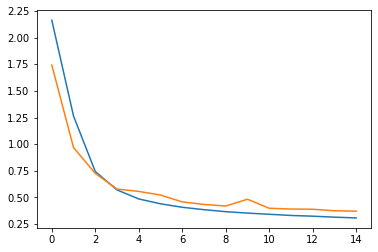

In [43]:
plt.plot(
    history.history['loss'],
    label='train'
)
plt.plot(
    history.history['val_loss'],
    label='test'
)

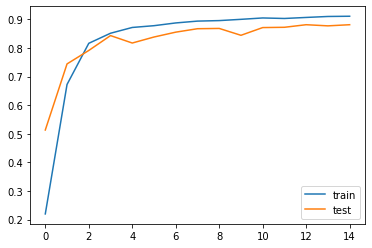

In [44]:
plt.plot(
    history.history['categorical_accuracy'],
    label='train'
)
plt.plot(
    history.history['val_categorical_accuracy'],
    label='test'
)
plt.legend()

## Looking at the kernels

Another interesting thing to do is to look at the kernels that were learned during the training stage. For example, let's look at the kernel for the first feature map. We use `model.weights` to see all the parameters

In [45]:
#model.weights

The kernels are stored as a $5 \times 5 \times 1 \times 10$ array. To pull out the first $5\times 5$ block we need to ask for all entries of the form $(i,j,0,0)$. In `numpy`, you can use `:` to include all entries along a specific axis. Thus, this is how we access what we need: 

In [46]:
all_kernels = model.weights[0]

In [47]:
kernel0 = all_kernels.numpy()[:,:,0,0]

In [48]:
kernel0

array([[-0.23060484, -0.19532263, -0.13874517, -0.13414195, -0.1340017 ],
       [ 0.14422935,  0.24755418,  0.34474537,  0.29112098,  0.1324787 ],
       [ 0.3134174 ,  0.56658584,  0.6314979 ,  0.45871145,  0.40026176],
       [ 0.40605745,  0.57242924,  0.63405704,  0.52885246,  0.4749453 ],
       [ 0.26376942,  0.16083257,  0.18427607,  0.2643053 ,  0.23517132]],
      dtype=float32)

Now that we have the kernel, we can plot it as a grayscale image.

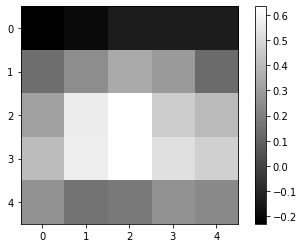

In [49]:
plt.imshow(kernel0, cmap='gray')
plt.colorbar()

By looking at the kernel like this, we can sometimes tell what feature it is looking for. But often, what we see is hard to interpret. Depending on how your training went, you may or may not see a recognizable feature such as an edge or gradient. Usually the image at least looks non-random.

## Exercise 1

Add a dropout layer which switches off half the neurons in the pooling layer by putting a dropout layer in between the pooling layer and the dense layer. Train your network again for 15 epochs and plot the accuracy on the training and validation data on a single plot as we did above. Take note of any differences between this plot and the one above.

In [50]:
model2 = keras.Sequential()
model2.add(keras.Input(shape=(28,28,1)))
model2.add(layers.Conv2D(filters=10, kernel_size=(5,5), activation='sigmoid', input_shape=(28,28,1)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Dropout((0.5)))
model2.add(layers.Flatten())
model2.add(layers.Dense(10, activation='sigmoid'))

In [51]:
model2.compile(
    optimizer=keras.optimizers.SGD(),  # Optimizer
    loss=keras.losses.CategoricalCrossentropy(), # Cost or loss function
    metrics=[keras.metrics.CategoricalAccuracy()],
)

In [52]:
history2 = model2.fit(
    training_inputs_28x28_small, training_labels_small,
    epochs=15, 
    batch_size=10,
    validation_data=(test_inputs_28x28_small, test_labels_small)
)

Epoch 1/15
500/500 [==============================] - 1s 2ms/step - loss: 2.4668 - categorical_accuracy: 0.1420 - val_loss: 2.0921 - val_categorical_accuracy: 0.2030
Epoch 2/15
500/500 [==============================] - 1s 1ms/step - loss: 1.6975 - categorical_accuracy: 0.4202 - val_loss: 1.1273 - val_categorical_accuracy: 0.7120
Epoch 3/15
500/500 [==============================] - 1s 1ms/step - loss: 1.0192 - categorical_accuracy: 0.6784 - val_loss: 0.8052 - val_categorical_accuracy: 0.7770
Epoch 4/15
500/500 [==============================] - 1s 1ms/step - loss: 0.7780 - categorical_accuracy: 0.7600 - val_loss: 0.6108 - val_categorical_accuracy: 0.8350
Epoch 5/15
500/500 [==============================] - 1s 1ms/step - loss: 0.6540 - categorical_accuracy: 0.7918 - val_loss: 0.5713 - val_categorical_accuracy: 0.8290
Epoch 6/15
500/500 [==============================] - 1s 1ms/step - loss: 0.5793 - categorical_accuracy: 0.8160 - val_loss: 0.5262 - val_categorical_accuracy: 0.8400
Epoc

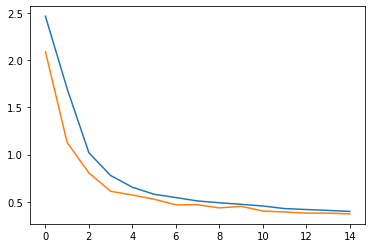

In [53]:
plt.plot(
    history2.history['loss'],
    label='train'
)
plt.plot(
    history2.history['val_loss'],
    label='test'
)

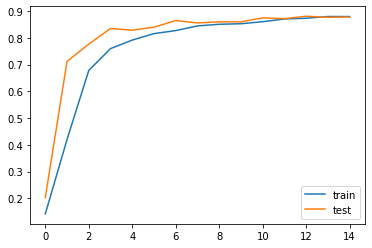

In [54]:
plt.plot(
    history2.history['categorical_accuracy'],
    label='train'
)
plt.plot(
    history2.history['val_categorical_accuracy'],
    label='test'
)
plt.legend()

With the dropout layer, the test data did slightly better than the training data rather than the other way around.  

## Exercise 2

Design a model with the same architecture above except use only one feature map with a $5\times 5$ kernel. Make a new training set consisting only of those images (in the first 5000 MNIST images) which are either a $1$ or a $7$. Train your network on this new training set for at least 50 epochs. Show, as a grayscale image, the value of the kernel (you should have only one) at the end of the training. 

In [55]:
##for reference
#training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
#training_data = list(training_data)[:5000]
#test_data = list(test_data)[:1000]

#training_inputs = [x[0] for x in training_data]
#training_labels = [x[1] for x in training_data]



In [56]:
test_inputs2_28x28 = np.array([x[0].reshape((28,28,1)) for x in test_data_small])
test_labels2 = np.array(tf.one_hot([x[1] for x in test_data_small], depth=10))

In [57]:
test_inputs2_28x28.shape

(1000, 28, 28, 1)

In [58]:
new_training_inputs = [] 
new_training_labels = []
for n in range(len(training_inputs)): 
    if training_labels[n][7] == np.array(1) or training_labels[n][1] == np.array(1):#checks if n input corresponds to label 1 or 7
        new_training_inputs.append(training_inputs[n])
        new_training_labels.append(training_labels[n])

new_training_inputs = np.array([x.reshape((28,28,1)) for x in new_training_inputs])
new_training_labels = np.array(new_training_labels)

In [59]:
new_training_inputs.shape, new_training_labels.shape

((10853, 28, 28, 1), (10853, 10, 1))

In [60]:
##double check it worked 
ones = [new_training_labels[n][1] == np.array(1) for n in range(len(new_training_labels))]
sevens = [new_training_labels[n][7] == np.array(1) for n in range(len(new_training_labels))]
num_ones = ones.count(True)
num_sevens = sevens.count(True)
print(len(new_training_labels) == num_ones+num_sevens)

True


In [61]:
model3 = keras.Sequential()
model3.add(keras.Input(shape=(28,28,1)))
model3.add(layers.Conv2D(filters=1, kernel_size=(5,5), activation='sigmoid', input_shape=(28,28,1))) #only one filter
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(10, activation='sigmoid'))

In [62]:
model3.compile(
    optimizer=keras.optimizers.SGD(),  # Optimizer
    loss=keras.losses.CategoricalCrossentropy(), # Cost or loss function
    metrics=[keras.metrics.CategoricalAccuracy()],
)

In [63]:
history3 = model3.fit(
    new_training_inputs, new_training_labels,
    epochs=50, 
    batch_size=10,
    validation_data=(test_inputs2_28x28, test_labels2)
)

Epoch 1/50
1086/1086 [==============================] - 2s 1ms/step - loss: 0.3702 - categorical_accuracy: 0.9024 - val_loss: 6.1505 - val_categorical_accuracy: 0.2140
Epoch 2/50
1086/1086 [==============================] - 2s 1ms/step - loss: 0.1125 - categorical_accuracy: 0.9748 - val_loss: 6.5401 - val_categorical_accuracy: 0.2160
Epoch 3/50
1086/1086 [==============================] - 2s 1ms/step - loss: 0.0831 - categorical_accuracy: 0.9780 - val_loss: 6.8318 - val_categorical_accuracy: 0.2170
Epoch 4/50
1086/1086 [==============================] - 2s 1ms/step - loss: 0.0695 - categorical_accuracy: 0.9813 - val_loss: 7.0695 - val_categorical_accuracy: 0.2170
Epoch 5/50
1086/1086 [==============================] - 2s 1ms/step - loss: 0.0608 - categorical_accuracy: 0.9834 - val_loss: 7.2221 - val_categorical_accuracy: 0.2190
Epoch 6/50
1086/1086 [==============================] - 2s 1ms/step - loss: 0.0546 - categorical_accuracy: 0.9843 - val_loss: 7.4278 - val_categorical_accuracy:

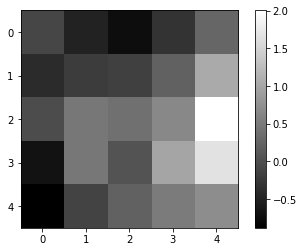

In [64]:
kernel = model3.weights[0]
kernel = kernel.numpy()[:,:,0,0]
plt.imshow(kernel, cmap='gray')
plt.colorbar()

## Challenge

It's time to see just how far you can go with the MNIST data. By using CNNs together with the various other tricks we've learned during this course, try and get the best accuracy you can on the MNIST test data. You are allowed to use the small 1000-image test set if you like, but if you can use the whole MNIST set, do so. You may have to use Jupyter on your own computer or a lab computer at UNCG ([here](https://jupyter.org/install) is how to install it). Or you can try using [Google Colab](https://colab.research.google.com/). 

Submit your code on Canvas and report your best accuracy on the test data in the submission comments. You will receive the point for the Challenge question for anything above 95% accuracy. The person who achieves the highest accuracy will get one bonus point.

In [65]:
training_inputs = [x[0] for x in training_data]
training_labels = [x[1] for x in training_data]
training_inputs_28x28 = np.array([x.reshape((28,28,1)) for x in training_inputs])
training_labels = np.array(training_labels)
test_inputs_28x28 = np.array([x[0].reshape((28,28,1)) for x in test_data])
test_labels = np.array(tf.one_hot([x[1] for x in test_data], depth=10))

In [66]:
training_inputs_28x28.shape

(50000, 28, 28, 1)

In [70]:
model4 = keras.Sequential()
model4.add(keras.Input(shape=(28,28,1)))
model4.add(layers.Conv2D(filters=15, kernel_size=(5,5), activation='sigmoid', input_shape=(28,28,1)))
model4.add(layers.MaxPooling2D((2,2)))
model4.add(layers.Conv2D(filters=10, kernel_size=(3,3), activation='sigmoid', input_shape=(12,12,15)))
model4.add(layers.MaxPooling2D((2,2)))
model4.add(layers.Dropout((0.3))) 
model4.add(layers.Flatten())
model4.add(layers.Dense(10, activation='sigmoid'))

In [71]:
model4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Optimizer https://keras.io/api/optimizers/adam/
    loss=keras.losses.CategoricalCrossentropy(), # Cost or loss function
    metrics=[keras.metrics.CategoricalAccuracy()],
)

In [72]:
history4 = model4.fit(
    training_inputs_28x28, training_labels,
    epochs=50, 
    batch_size=10,
    validation_data=(test_inputs_28x28, test_labels)
)

Epoch 1/50
5000/5000 [==============================] - 10s 2ms/step - loss: 1.0893 - categorical_accuracy: 0.6359 - val_loss: 0.3258 - val_categorical_accuracy: 0.9080
Epoch 2/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.3222 - categorical_accuracy: 0.9053 - val_loss: 0.1748 - val_categorical_accuracy: 0.9518
Epoch 3/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.2178 - categorical_accuracy: 0.9329 - val_loss: 0.1230 - val_categorical_accuracy: 0.9647
Epoch 4/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.1745 - categorical_accuracy: 0.9464 - val_loss: 0.0997 - val_categorical_accuracy: 0.9715
Epoch 5/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.1502 - categorical_accuracy: 0.9540 - val_loss: 0.0906 - val_categorical_accuracy: 0.9729
Epoch 6/50
5000/5000 [==============================] - 9s 2ms/step - loss: 0.1395 - categorical_accuracy: 0.9570 - val_loss: 0.0788 - val_categorical_accu

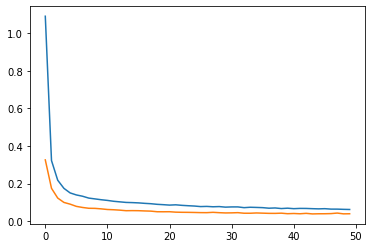

In [73]:
plt.plot(
    history4.history['loss'],
    label='train'
)
plt.plot(
    history4.history['val_loss'],
    label='test'
)

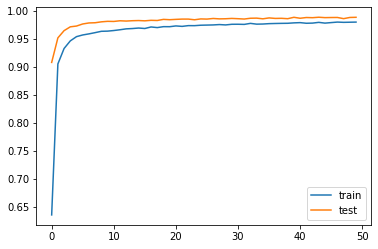

In [74]:
plt.plot(
    history4.history['categorical_accuracy'],
    label='train'
)
plt.plot(
    history4.history['val_categorical_accuracy'],
    label='test'
)
plt.legend()

In [75]:
model4.save('mymodel4')
model4 = keras.models.load_model('mymodel4')
model4.evaluate(test_inputs_28x28, test_labels)

INFO:tensorflow:Assets written to: mymodel4\assets
313/313 [==============================] - 1s 2ms/step - loss: 0.0396 - categorical_accuracy: 0.9885


[0.03955026715993881, 0.9884999990463257]